<a href="https://colab.research.google.com/github/dan9111/DataSciencePortfolioProject/blob/main/IDX%20Stock%20Prediction%20LSTM/IDX_Stock_Prediction_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

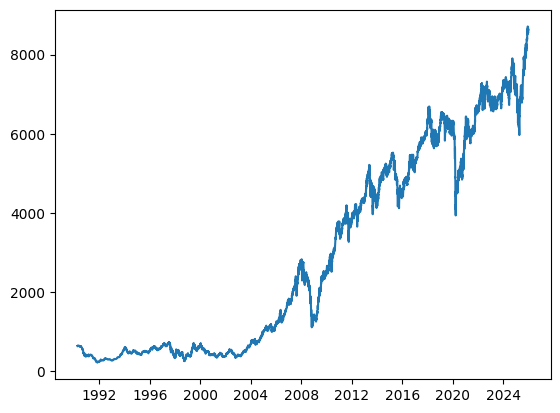

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1990-04-06 00:00:00+07:00,641.244019,641.244019,641.244019,641.244019,0,0.0,0.0
1990-04-09 00:00:00+07:00,633.457336,633.457336,633.457336,633.457336,0,0.0,0.0
1990-04-10 00:00:00+07:00,632.061340,632.061340,632.061340,632.061340,0,0.0,0.0
1990-04-11 00:00:00+07:00,634.668274,634.668274,634.668274,634.668274,0,0.0,0.0
1990-04-12 00:00:00+07:00,639.589111,639.589111,639.589111,639.589111,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-12-18 00:00:00+07:00,8705.137695,8730.708984,8618.195312,8618.195312,328562900,0.0,0.0
2025-12-19 00:00:00+07:00,8657.242188,8671.767578,8562.887695,8609.550781,307160800,0.0,0.0
2025-12-22 00:00:00+07:00,8629.246094,8648.794922,8609.388672,8645.843750,374939200,0.0,0.0


In [35]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

idx = yf.Ticker('^JKSE')
idx = pd.DataFrame(idx.history(period='max'))

plt.plot(idx['Close'])
plt.show()
idx

In [36]:
# Measure volatility
idx['Return'] = idx['Close'].pct_change()
annual_volatility = idx['Return'].std() * (252**0.5)
print(f'IDX Annual volatility: {annual_volatility}')

IDX Annual volatility: 0.21671024440534384


# **LSTM** Model

In [37]:
idx = idx[["Close"]].copy()
idx.describe()

,Close
count,8702.000000
mean,2908.525113
std,2542.446881
min,223.240311
25%,507.983963
50%,1994.262878
75%,5247.337158
max,8710.695312


In [38]:
from tensorflow import keras
import numpy as np

Split train and test

In [39]:
X = idx.values
window_size = 60
size = int(np.ceil(len(X)*0.8))
train, test = X[:size], X[size-window_size:]

Normalize data

In [40]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [41]:
X_train, y_train = [], []

for i in range(window_size, len(train)):
  X_train.append(train[i-window_size:i, 0])
  y_train.append(train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64, return_sequences=False))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
training = model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 18s 55ms/step - loss: 0.0749 - root_mean_squared_error: 0.1375
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0355 - root_mean_squared_error: 0.0649
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - loss: 0.0345 - root_mean_squared_error: 0.0625
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - loss: 0.0332 - root_mean_squared_error: 0.0603
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.0317 - root_mean_squared_error: 0.0578
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0323 - root_mean_squared_error: 0.0583
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 0.0300 - root_mean_squared_error: 0.0540
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.0307 - root_mean_squared_error: 0.0541
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 0.0304 - root_mean_squared_error: 0.0534
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 0.0312 - r

In [44]:
test = scaler.transform(test)
X_test, y_test = [], X[size:]
for i in range(60, len(test)):
  X_test.append(test[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [45]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


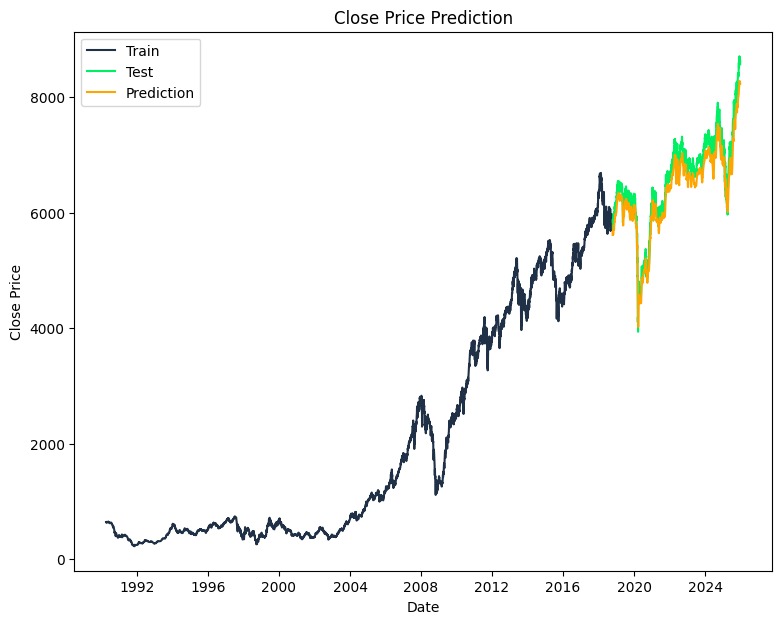

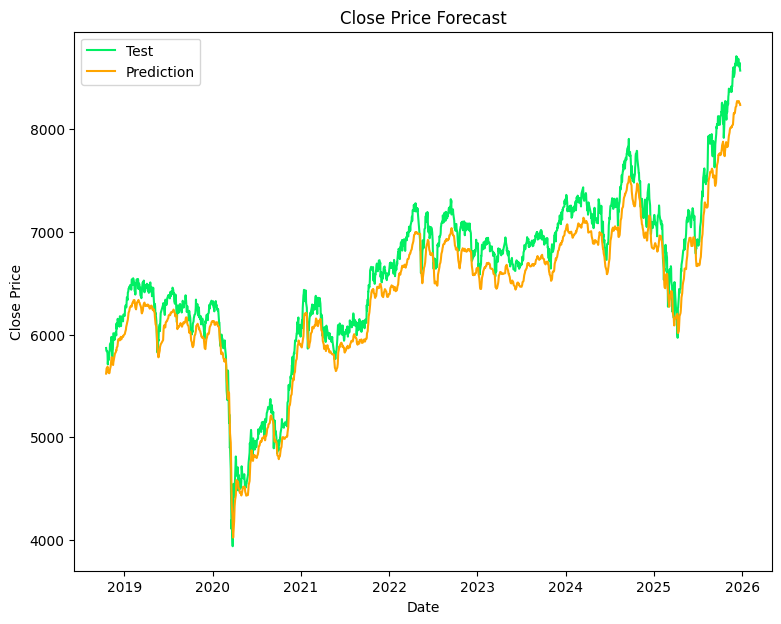

In [46]:
train_plot = idx[:size]
test_plot = idx[size:]

test_plot = test_plot.copy()
# fill first 60 rows to null
# add 60 null to predictions
#null = np.array([np.nan]*60)
# reshape into two dimension
#predictions = predictions.reshape(-1)
#predictions = np.concatenate((null, predictions))
#predictions.shape
test_plot['Predictions'] = y_pred

plt.figure(figsize=(9,7))
plt.plot(train_plot['Close'], label='Train', color='#203147')
plt.plot(test_plot['Close'], label='Test', color='#01ef63')
plt.plot(test_plot['Predictions'], label='Prediction', color='orange')
plt.title('Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

plt.figure(figsize=(9,7))
plt.plot(test_plot['Close'], label='Test', color='#01ef63')
plt.plot(test_plot['Predictions'], label='Prediction', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [48]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

RMSE: 227.61426751651928
MAE: 210.07506454292385
R2: 0.9174309797208032


In [49]:
y_test_naive = y_test[1:]
y_pred_naive = y_pred[:-1]

naive_rmse = np.sqrt(mean_squared_error(y_test_naive, y_pred_naive))
print(f'Naive RMSE: {naive_rmse}')
if rmse < naive_rmse:
    print("SUCCESS: Model beats the naive baseline.")
else:
    print("FAIL: Model is worse than just guessing yesterday's price.")

Naive RMSE: 236.9408111050061
SUCCESS: Model beats the naive baseline.


In [50]:
actual_change = np.diff(y_test.flatten())
predicted_change = np.diff(y_pred.flatten())

direction = np.sign(actual_change) == np.sign(predicted_change)
accuracy = np.mean(direction)*100

print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 49.86%


# **LSTM** Model: Return

In [51]:
idx = yf.Ticker('^JKSE')
# move ticker to pandas
idx = pd.DataFrame(idx.history(period='max'))
idx.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)
idx

,Open,High,Low,Close
Date,,,,
1990-04-06 00:00:00+07:00,641.244019,641.244019,641.244019,641.244019
1990-04-09 00:00:00+07:00,633.457336,633.457336,633.457336,633.457336
1990-04-10 00:00:00+07:00,632.061340,632.061340,632.061340,632.061340
1990-04-11 00:00:00+07:00,634.668274,634.668274,634.668274,634.668274
1990-04-12 00:00:00+07:00,639.589111,639.589111,639.589111,639.589111
...,...,...,...,...
2025-12-18 00:00:00+07:00,8705.137695,8730.708984,8618.195312,8618.195312
2025-12-19 00:00:00+07:00,8657.242188,8671.767578,8562.887695,8609.550781
2025-12-22 00:00:00+07:00,8629.246094,8648.794922,8609.388672,8645.843750


In [52]:
# Find daily return
idx['Return'] = idx['Close'].pct_change()
#idx['Return'] = (idx['Close']/idx['Close'].shift(-1)) - 1
idx = idx.dropna()
idx

,Open,High,Low,Close,Return
Date,,,,,
1990-04-09 00:00:00+07:00,633.457336,633.457336,633.457336,633.457336,-0.012143
1990-04-10 00:00:00+07:00,632.061340,632.061340,632.061340,632.061340,-0.002204
1990-04-11 00:00:00+07:00,634.668274,634.668274,634.668274,634.668274,0.004124
1990-04-12 00:00:00+07:00,639.589111,639.589111,639.589111,639.589111,0.007753
1990-04-16 00:00:00+07:00,639.989075,639.989075,639.989075,639.989075,0.000625
...,...,...,...,...,...
2025-12-18 00:00:00+07:00,8705.137695,8730.708984,8618.195312,8618.195312,-0.006817
2025-12-19 00:00:00+07:00,8657.242188,8671.767578,8562.887695,8609.550781,-0.001003
2025-12-22 00:00:00+07:00,8629.246094,8648.794922,8609.388672,8645.843750,0.004215


In [53]:
idx_return = idx[['Return']].copy()
idx_return.describe()

,Return
count,8701.000000
mean,0.000391
std,0.013651
min,-0.119549
25%,-0.005380
50%,0.000588
75%,0.006439
max,0.140283


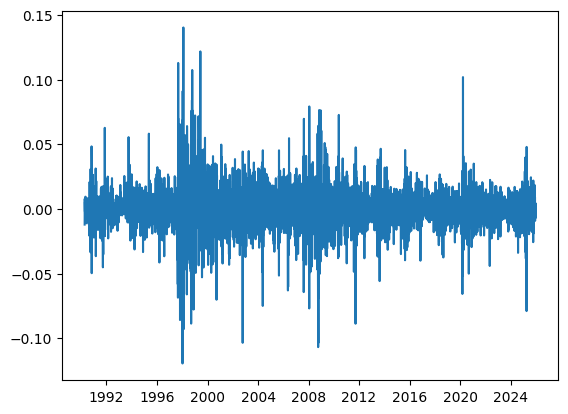

In [68]:
plt.plot(idx_return['Return'])
plt.show()

In [54]:
X = idx_return.values
window_size = 60
training_size = int(np.ceil(len(X)*0.8))
train, test = X[:size], X[size-window_size:]

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train)
train = scaler.transform(train)

In [56]:
X_train, y_train = [], []

for i in range(window_size, len(train)):
  X_train.append(train[i-window_size:i, 0])
  y_train.append(train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64, return_sequences=False))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
training = model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 0.6493 - root_mean_squared_error: 0.9698
Epoch 2/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.6539 - root_mean_squared_error: 0.9803
Epoch 3/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.6728 - root_mean_squared_error: 1.0330
Epoch 4/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.6576 - root_mean_squared_error: 0.9874
Epoch 5/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.6538 - root_mean_squared_error: 0.9916
Epoch 6/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.6499 - root_mean_squared_error: 0.9986
Epoch 7/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.6619 - root_mean_squared_error: 0.9973
Epoch 8/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - loss: 0.6283 - root_mean_squared_error: 0.9355
Epoch 9/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.6501 - root_mean_squared_error: 0.9780
Epoch 10/20
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 0.6668 - r

In [59]:
test = scaler.transform(test)
X_test, y_test = [], X[size:]
for i in range(60, len(test)):
  X_test.append(test[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [60]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [61]:
y_pred

array([[0.0014237 ],
       [0.00066616],
       [0.0007095 ],
       ...,
       [0.00067673],
       [0.00098174],
       [0.0003857 ]], dtype=float32)

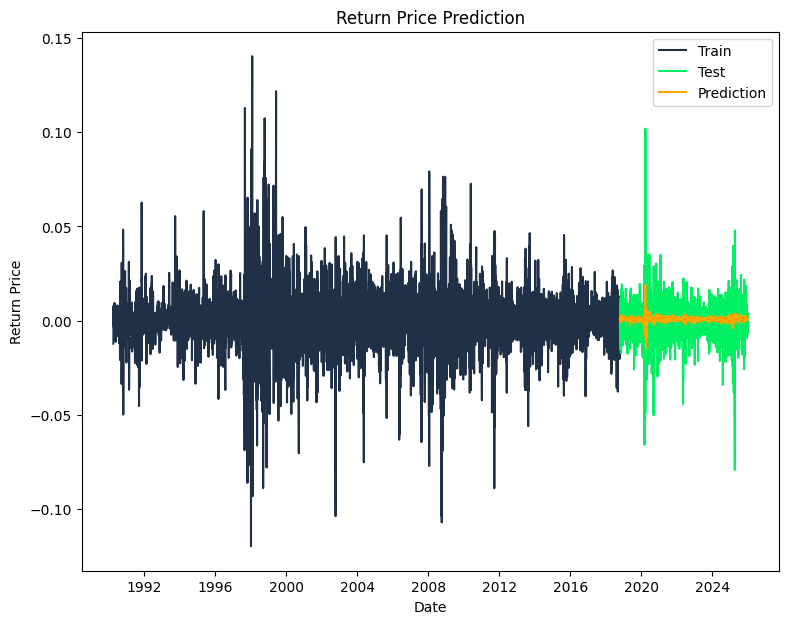

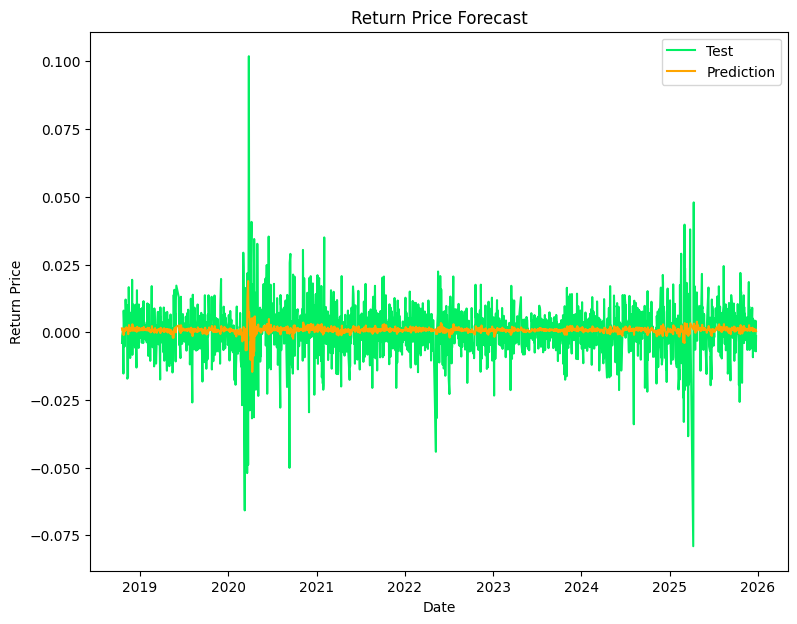

In [62]:
train_plot = idx_return[:size]
test_plot = idx_return[size:]

test_plot = test_plot.copy()
# fill first 60 rows to null
# add 60 null to predictions
#null = np.array([np.nan]*60)
# reshape into two dimension
#predictions = predictions.reshape(-1)
#predictions = np.concatenate((null, predictions))
#predictions.shape
test_plot['Predictions'] = y_pred

plt.figure(figsize=(9,7))
plt.plot(train_plot['Return'], label='Train', color='#203147')
plt.plot(test_plot['Return'], label='Test', color='#01ef63')
plt.plot(test_plot['Predictions'], label='Prediction', color='orange')
plt.title('Return Price Prediction')
plt.xlabel('Date')
plt.ylabel('Return Price')
plt.legend()
plt.show()

plt.figure(figsize=(9,7))
plt.plot(test_plot['Return'], label='Test', color='#01ef63')
plt.plot(test_plot['Predictions'], label='Prediction', color='orange')
plt.title('Return Price Forecast')
plt.xlabel('Date')
plt.ylabel('Return Price')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [64]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2: {r2}')

RMSE: 0.010262612495699272
MAE: 0.007088988009326103
R2: -0.01792330514354834


In [65]:
y_test_naive = y_test[1:]
y_pred_naive = y_pred[:-1]

naive_rmse = np.sqrt(mean_squared_error(y_test_naive, y_pred_naive))
print(f'Naive RMSE: {naive_rmse}')
if rmse < naive_rmse:
    print("SUCCESS: Model beats the naive baseline.")
else:
    print("FAIL: Model is worse than just guessing yesterday's price.")

Naive RMSE: 0.01025447565473317
FAIL: Model is worse than just guessing yesterday's price.


In [66]:
actual_change = np.diff(y_test.flatten())
predicted_change = np.diff(y_pred.flatten())

direction = np.sign(actual_change) == np.sign(predicted_change)
accuracy = np.mean(direction)*100

print(f'Accuracy: {accuracy:.2f}%')

Accuracy: 31.99%
